In [9]:
import pandas as pd
import os
from tqdm import tqdm
import numpy as np

# ============================================================
# CELL 1: Load and preprocess Priceandothers.csv
# ============================================================

# Define file paths
file_paths = r'C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/RAW DATA (WHARTON - CRSP)/All_CRSP_Monthly_Stocks.csv'
output_dir = r'C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/PREPROCESSED DATA/'

# Load the CSV file
with tqdm(total=1, desc="Loading CSV") as pbar:
    df_price = pd.read_csv(file_paths)
    pbar.update(1)

# Convert date to datetime
with tqdm(total=1, desc="Converting dates") as pbar:
    df_price['date'] = pd.to_datetime(df_price['date'], errors='coerce')
    pbar.update(1)

# Preview the raw data (limited columns)
pd.set_option('display.max_columns', 20)
print(df_price.head())
pd.set_option('display.max_columns', None)

# Data cleaning, including DLRET handling
with tqdm(total=6, desc="Cleaning data and adjusting RET with DLRET") as pbar:
    df_price['RET'] = pd.to_numeric(df_price['RET'], errors='coerce')
    pbar.update(1)
    df_price['DLRET'] = pd.to_numeric(df_price['DLRET'], errors='coerce')
    pbar.update(1)
    df_price['RET'] = df_price['RET'] + df_price['DLRET'].fillna(0)
    pbar.update(1)
    df_price['RET'] = df_price['RET'].clip(lower=-1)
    pbar.update(1)
    df_price['vwretd'] = pd.to_numeric(df_price['vwretd'], errors='coerce')
    pbar.update(1)
    df_price['ewretd'] = pd.to_numeric(df_price['ewretd'], errors='coerce')
    pbar.update(1)

# ============================================================
# FILTER: Keep only stocks (SHRCD == 10 or 11)
# ============================================================

with tqdm(total=1, desc="Filtering for stocks only (SHRCD 10/11)") as pbar:
    # Convert SHRCD to numeric to handle any potential issues
    df_price['SHRCD'] = pd.to_numeric(df_price['SHRCD'], errors='coerce')
    
    # Count before filtering
    initial_permnos = df_price['PERMNO'].nunique()
    initial_rows = len(df_price)
    
    # Filter: Keep only stocks (SHRCD == 10 or 11)
    # SPY ETF removed - using VWRETD market index instead
    df_price = df_price[df_price['SHRCD'].isin([10, 11])]
    
    # Count after filtering
    filtered_permnos = df_price['PERMNO'].nunique()
    filtered_rows = len(df_price)
    
    print(f"Initial unique PERMNOs: {initial_permnos}, Rows: {initial_rows}")
    print(f"After stock filter unique PERMNOs: {filtered_permnos}, Rows: {filtered_rows}")
    print(f"Dropped {initial_permnos - filtered_permnos} non-stock PERMNOs ({(initial_permnos - filtered_permnos) / initial_permnos * 100:.2f}%)")
    print("Note: SPY ETF excluded - using VWRETD (PERMNO 99999999) as market index")
    
    pbar.update(1)

# ============================================================
# FILTER: Price > $1 and Market Cap > $10M  # MODIFIED: Relaxed thresholds for more early stocks
# ============================================================

with tqdm(total=1, desc="Filtering for price > $1 and market cap > $10M") as pbar:
    # Convert necessary columns to numeric
    df_price['PRC'] = pd.to_numeric(df_price['PRC'], errors='coerce')
    df_price['SHROUT'] = pd.to_numeric(df_price['SHROUT'], errors='coerce')
    
    # Fix negative prices (take absolute value)
    df_price['PRC'] = df_price['PRC'].abs()
    
    # Calculate market cap (in millions): PRC * SHROUT / 1000
    # SHROUT is in thousands, so PRC * SHROUT / 1000 gives market cap in millions
    df_price['MKTCAP'] = df_price['PRC'] * df_price['SHROUT'] / 1000
    
    # Count before filtering
    before_price_filter = df_price['PERMNO'].nunique()
    
    # Apply filters:
    # MODIFIED: Price > $1 (was $5), Market Cap > $10M (was $50M)
    df_price = df_price[
        (df_price['PRC'] > 1) & 
        (df_price['MKTCAP'] > 10)
    ]
    
    # Count after filtering
    after_price_filter = df_price['PERMNO'].nunique()
    
    print(f"Before price/mktcap filter: {before_price_filter} unique PERMNOs")
    print(f"After price/mktcap filter: {after_price_filter} unique PERMNOs")
    print(f"Dropped {before_price_filter - after_price_filter} PERMNOs ({(before_price_filter - after_price_filter) / before_price_filter * 100:.2f}%)")
    print(f"Filters applied: PRC > $1, MKTCAP > $10M")  # Updated print
    
    pbar.update(1)

# ============================================================
# CELL 2: Ensure limited missing RET values between first and last valid
# ============================================================

with tqdm(total=1, desc="Filtering for limited missing RET values") as pbar:
    # Pivot the RET values
    pivot_ret = df_price.pivot_table(index='PERMNO', columns='date', values='RET', aggfunc='first')

    # Get all unique PERMNOs before filtering
    all_permnos = pivot_ret.index.unique()
    total_stocks = len(all_permnos)

    # Find valid PERMNOs with <=5 missing between first and last valid RET  # MODIFIED: Increased from <=3 to <=5
    first_valid_dates = pivot_ret.apply(lambda row: row.first_valid_index(), axis=1)
    last_valid_dates = pivot_ret.apply(lambda row: row.last_valid_index(), axis=1)

    valid_permnos = []
    for permno in pivot_ret.index:
        first_date = first_valid_dates[permno]
        last_date = last_valid_dates[permno]
        if first_date is not None and last_date is not None:
            date_range = pivot_ret.columns[(pivot_ret.columns >= first_date) & (pivot_ret.columns <= last_date)]
            missing_count = pivot_ret.loc[permno, date_range].isna().sum()
            if missing_count <= 5:  # MODIFIED: Relaxed threshold
                valid_permnos.append(permno)

    # Calculate percentage of stocks with >5 missing (dropped)
    dropped_stocks = total_stocks - len(valid_permnos)
    dropped_percentage = (dropped_stocks / total_stocks * 100) if total_stocks > 0 else 0
    print(f"Percentage of stocks with more than 5 missing RET between first and last valid: {dropped_percentage:.2f}%")
    print(f"Number of stocks kept: {len(valid_permnos)}")

    # Filter pivot to valid PERMNOs
    pivot_ret = pivot_ret[pivot_ret.index.isin(valid_permnos)].reset_index()

    if pivot_ret.empty:
        print("⚠️ Warning: No stocks with <=5 missing RET found.")
    pbar.update(1)

# ============================================================
# CELL 3: Remove suspicious leading/trailing zero sequences
# ============================================================

with tqdm(total=1, desc="Removing suspicious zero sequences") as pbar:
    date_cols = [col for col in pivot_ret.columns if isinstance(col, pd.Timestamp)]
    
    for i in range(len(pivot_ret)):
        series = pivot_ret.loc[i, date_cols]
        first_date = series.first_valid_index()
        last_date = series.last_valid_index()
        
        if first_date is None or last_date is None:
            continue
        
        date_range = [col for col in date_cols if col >= first_date and col <= last_date]
        
        # Leading zeros
        lead_count = 0
        for col in date_range:
            val = series[col]
            if pd.isna(val):
                break
            if val == 0.0:
                lead_count += 1
            else:
                break
        if lead_count >= 5:  # MODIFIED: Increased from >=3 to >=5 for more leniency
            pivot_ret.loc[i, date_range[:lead_count]] = np.nan
        
        # Trailing zeros
        trail_count = 0
        for col in reversed(date_range):
            val = series[col]
            if pd.isna(val):
                break
            if val == 0.0:
                trail_count += 1
            else:
                break
        if trail_count >= 5:  # MODIFIED: Increased from >=3 to >=5
            pivot_ret.loc[i, date_range[-trail_count:]] = np.nan
    
    pbar.update(1)

# ============================================================
# CELL 4: Add company names and tickers
# ============================================================

with tqdm(total=1, desc="Adding COMNAM and TICKER") as pbar:
    comnam_ticker_map = df_price.groupby('PERMNO')[['COMNAM', 'TICKER']].last().reset_index()
    
    # Handle missing TICKER or COMNAM values
    comnam_ticker_map['COMNAM'] = comnam_ticker_map['COMNAM'].fillna('Unknown Company')
    comnam_ticker_map['TICKER'] = comnam_ticker_map['TICKER'].fillna('N/A')
    
    # Create Company_Ticker column
    comnam_ticker_map['Company_Ticker'] = comnam_ticker_map['COMNAM'] + ' (' + comnam_ticker_map['TICKER'] + ')'
    
    pivot_ret = pd.merge(pivot_ret, comnam_ticker_map[['PERMNO', 'Company_Ticker']], on='PERMNO', how='left')
    pbar.update(1)

# ============================================================
# CELL 5: Reorder columns
# ============================================================

with tqdm(total=1, desc="Reordering columns") as pbar:
    cols = ['PERMNO', 'Company_Ticker'] + [col for col in pivot_ret.columns if col not in ['PERMNO', 'Company_Ticker']]
    pivot_ret = pivot_ret[cols]
    pbar.update(1)

# ============================================================
# CELL 6: Prepare benchmarks (INCLUDING VWRETD AS MARKET INDEX)
# ============================================================

with tqdm(total=1, desc="Preparing benchmarks") as pbar:
    benchmarks = df_price.groupby('date')[['vwretd', 'ewretd']].first().reset_index()
    pbar.update(1)

# ============================================================
# CELL 7: Pivot benchmarks (INCLUDING VWRETD AS MARKET INDEX)
# ============================================================

with tqdm(total=2, desc="Pivoting benchmarks") as pbar:
    benchmarks_melted = benchmarks.melt(
        id_vars=['date'],
        value_vars=['vwretd', 'ewretd'],
        var_name='metric',
        value_name='value'
    )
    pbar.update(1)

    benchmarks_pivot = benchmarks_melted.pivot_table(
        index='metric', columns='date', values='value', aggfunc='first'
    ).reset_index()
    pbar.update(1)

# ============================================================
# CELL 8: Format benchmarks (ADD PERMNO FOR MARKET INDEX)
# ============================================================

with tqdm(total=1, desc="Formatting benchmarks") as pbar:
    # Add PERMNO column for benchmarks (use special identifier for market index)
    benchmarks_pivot['PERMNO'] = benchmarks_pivot['metric'].map({
        'vwretd': 99999999,  # Special PERMNO for CRSP Value-Weighted Market Index
        'ewretd': 99999998   # Special PERMNO for Equal-Weighted Market Index
    })
    
    benchmarks_pivot['Company_Ticker'] = benchmarks_pivot['metric'].map({
        'vwretd': 'CRSP Value-Weighted Market Index (VWRETD)',
        'ewretd': 'CRSP Equal-Weighted Market Index (EWRETD)'
    })
    benchmarks_pivot = benchmarks_pivot.drop(columns=['metric'])
    benchmarks_pivot = benchmarks_pivot[['PERMNO', 'Company_Ticker'] +
                                        [col for col in benchmarks_pivot.columns if col not in ['PERMNO', 'Company_Ticker']]]
    pbar.update(1)

print("\n" + "="*70)
print("MARKET INDEX ADDED")
print("="*70)
print("✅ VWRETD (Value-Weighted Market Return) added as PERMNO 99999999")
print("✅ This provides continuous market data from 1926 onwards")
print("✅ Use PERMNO 99999999 instead of 84398 (SPY) for market proxy")
print("="*70 + "\n")

# ============================================================
# CELL 9: Concatenate with benchmarks
# ============================================================

with tqdm(total=1, desc="Concatenating with benchmarks") as pbar:
    pivot_ret_with_bench = pd.concat([pivot_ret, benchmarks_pivot], ignore_index=True)
    pbar.update(1)

# ============================================================
# CELL 10: Sort and preview
# ============================================================

with tqdm(total=1, desc="Sorting by Company_Ticker") as pbar:
    pivot_ret_with_bench = pivot_ret_with_bench.sort_values(by='Company_Ticker', ignore_index=True)
    pbar.update(1)

sheet_df = pivot_ret_with_bench  # Final result

# Round numerics to 4 decimals
with tqdm(total=1, desc="Rounding numerics to 4 decimals") as pbar:
    numeric_cols = sheet_df.select_dtypes(include=['number']).columns
    if 'PERMNO' in numeric_cols:
        numeric_cols = numeric_cols.drop('PERMNO')
    sheet_df[numeric_cols] = sheet_df[numeric_cols].round(4)
    pbar.update(1)

pd.set_option('display.max_columns', 20)
print("RET Pivot with Benchmarks Preview (Company_Ticker rows, dates columns, with missing values allowed per rules):")
print(sheet_df.head())
print("\nLast rows (benchmarks including VWRETD market index):")
print(sheet_df.tail(3))
pd.set_option('display.max_columns', None)

# ============================================================
# CELL 11: Save to CSV
# ============================================================

with tqdm(total=1, desc="Saving to CSV") as pbar:
    df = sheet_df
    sheet_name = 'ADA-HRP-Preprocessed-DATA'
    if df is None or df.empty:
        print(f"⚠️ Warning: {sheet_name} is empty or None. Skipping save.")
    else:
        df_copy = df.copy()
        for col in df_copy.columns:
            if pd.api.types.is_datetime64_any_dtype(df_copy[col]):
                df_copy[col] = df_copy[col].dt.strftime('%Y-%m-%d')
        df_copy.columns = [str(col).replace(':', '_').replace('/', '_') for col in df_copy.columns]
        output_csv = os.path.join(output_dir, f'{sheet_name}.csv')
        df_copy.to_csv(output_csv, index=False)
        print(f"✅ Successfully wrote {sheet_name} to {output_csv}")
    pbar.update(1)

Loading CSV:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\lucas\AppData\Local\Temp\ipykernel_28964\86926629.py:16: DtypeWarning: Columns (5,6,9,18,19,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df_price = pd.read_csv(file_paths)
C:\Users\lucas\AppData\Local\Temp\ipykernel_28964\86926629.py:16: DtypeWarning: Columns (5,6,9,18,19,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df_price = pd.read_csv(file_paths)
Converting dates: 100%|██████████| 1/1 [00:04<00:00,  4.06s/it]


   PERMNO       date    NAMEENDT  SHRCD  EXCHCD   SICCD    NCUSIP TICKER  \
0   10000 1985-12-31         NaN    NaN     NaN     NaN       NaN    NaN   
1   10000 1986-01-31  1986-12-03   10.0     3.0  3990.0  68391610  OMFGA   
2   10000 1986-02-28         NaN   10.0     3.0  3990.0  68391610  OMFGA   
3   10000 1986-03-31         NaN   10.0     3.0  3990.0  68391610  OMFGA   
4   10000 1986-04-30         NaN   10.0     3.0  3990.0  68391610  OMFGA   

                      COMNAM SHRCLS  ... CFACSHR  ALTPRC SPREAD    ALTPRCDT  \
0                        NaN    NaN  ...     NaN -2.5625    NaN  1986-01-07   
1  OPTIMUM MANUFACTURING INC      A  ...     1.0 -4.3750  0.250  1986-01-31   
2  OPTIMUM MANUFACTURING INC      A  ...     1.0 -3.2500  0.250  1986-02-28   
3  OPTIMUM MANUFACTURING INC      A  ...     1.0 -4.4375  0.125  1986-03-31   
4  OPTIMUM MANUFACTURING INC      A  ...     1.0 -4.0000  0.250  1986-04-30   

        RETX    vwretd    vwretx    ewretd    ewretx    sprtrn  
0  

Filtering for stocks only (SHRCD 10/11): 100%|██████████| 1/1 [00:07<00:00,  7.16s/it]


Initial unique PERMNOs: 38843, Rows: 5218898
After stock filter unique PERMNOs: 26746, Rows: 3922304
Dropped 12097 non-stock PERMNOs (31.14%)
Note: SPY ETF excluded - using VWRETD (PERMNO 99999999) as market index


Filtering for price > $1 and market cap > $10M: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


Before price/mktcap filter: 26746 unique PERMNOs
After price/mktcap filter: 24466 unique PERMNOs
Dropped 2280 PERMNOs (8.52%)
Filters applied: PRC > $1, MKTCAP > $10M


Filtering for limited missing RET values:   0%|          | 0/1 [00:00<?, ?it/s]

Percentage of stocks with more than 5 missing RET between first and last valid: 27.95%
Number of stocks kept: 17552


Removing suspicious zero sequences:   0%|          | 0/1 [00:00<?, ?it/s]

Saving to CSV: 100%|██████████| 1/1 [00:58<00:00, 58.05s/it]

✅ Successfully wrote ADA-HRP-Preprocessed-DATA to C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/PREPROCESSED DATA/ADA-HRP-Preprocessed-DATA.csv


TOP 10 DATES WITH LEAST VALID VALUES
1932-05-31: 126 valid stocks
1932-06-30: 129 valid stocks
1933-02-28: 142 valid stocks
1933-03-31: 143 valid stocks
1932-04-30: 144 valid stocks
1932-12-31: 144 valid stocks
1932-07-30: 145 valid stocks
1932-10-31: 145 valid stocks
1933-01-31: 145 valid stocks
1933-04-29: 145 valid stocks


SUMMARY STATISTICS
Mean valid stocks per quarter: 1754.43
Median valid stocks per quarter: 1998
Minimum valid stocks: 126 (on 1932-05-31)
Maximum valid stocks: 4813 (on 1997-11-28)
Total quarters analyzed: 1188

SUMMARY STATISTICS
Mean valid stocks per quarter: 1754.43
Median valid stocks per quarter: 1998
Minimum valid stocks: 126 (on 1932-05-31)
Maximum valid stocks: 4813 (on 1997-11-28)
Total quarters analyzed: 1188


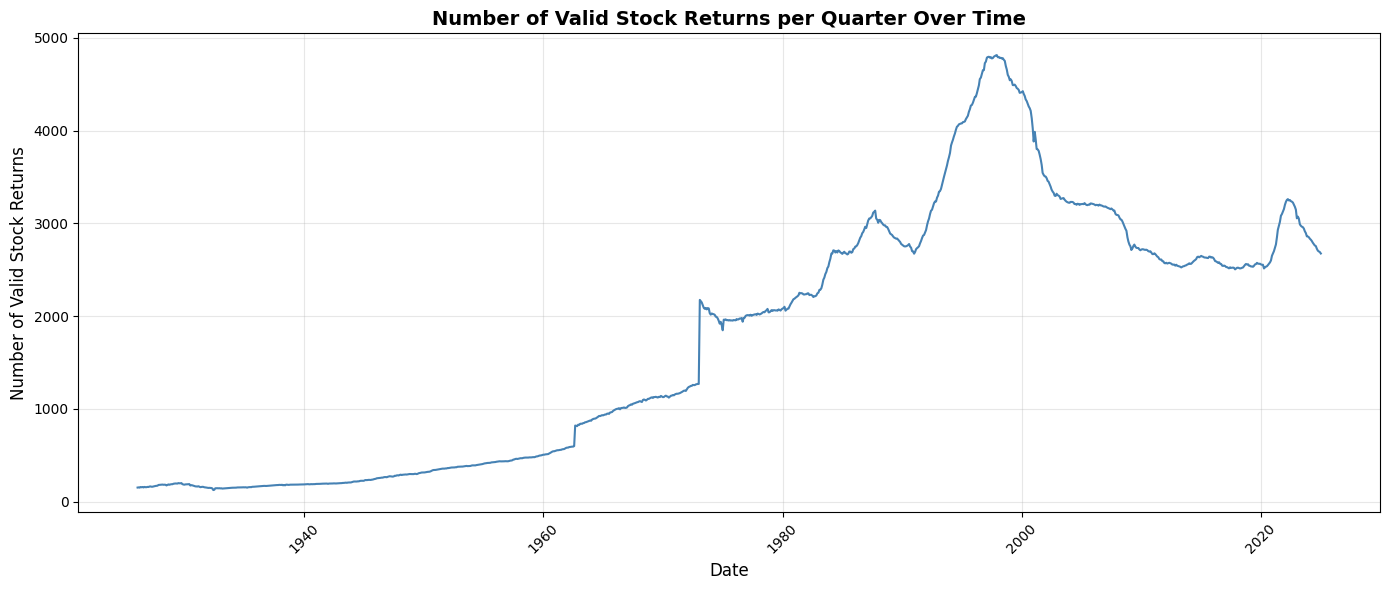

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the preprocessed data
output_csv = r'C:/Users/lucas/OneDrive/Bureau/HRP/DATA (CRSP)/PREPROCESSED DATA/ADA-HRP-Preprocessed-DATA.csv'
df = pd.read_csv(output_csv)

# Filter out benchmark rows (PERMNO 99999999 and 99999998)
stocks_only = df[~df['PERMNO'].isin([99999999, 99999998])].copy()

# Get date columns (all columns except PERMNO and Company_Ticker)
date_cols = [col for col in stocks_only.columns if col not in ['PERMNO', 'Company_Ticker']]

# Convert date columns to datetime for proper sorting
# Handle underscores in date format from CSV saving (e.g., '1926-01-30 00_00_00')
date_cols_sorted = sorted([pd.to_datetime(col.replace('_', ':')) for col in date_cols])

# Count valid (non-NaN) values for each date
valid_counts = []
date_labels = []

for date in date_cols_sorted:
    # Find the matching column name in the original data (with underscores)
    date_str_csv = date.strftime('%Y-%m-%d %H:%M:%S').replace(':', '_')
    
    # Look for the column (it might be in different formats)
    matching_col = None
    for col in date_cols:
        if col.replace('_', ':') == date.strftime('%Y-%m-%d %H:%M:%S'):
            matching_col = col
            break
    
    if matching_col:
        valid_count = stocks_only[matching_col].notna().sum()
        valid_counts.append(valid_count)
        date_labels.append(date)

# Create a DataFrame for easier analysis
analysis_df = pd.DataFrame({
    'Date': date_labels,
    'Valid_Count': valid_counts
})

# Get top 10 dates with LEAST valid values
least_valid = analysis_df.nsmallest(10, 'Valid_Count')

print("="*70)
print("TOP 10 DATES WITH LEAST VALID VALUES")
print("="*70)
for idx, row in least_valid.iterrows():
    print(f"{row['Date'].strftime('%Y-%m-%d')}: {row['Valid_Count']} valid stocks")
print("="*70 + "\n")

# Plot the number of valid values over time
plt.figure(figsize=(14, 6))
plt.plot(date_labels, valid_counts, linewidth=1.5, color='steelblue')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Valid Stock Returns', fontsize=12)
plt.title('Number of Valid Stock Returns per Quarter Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

# Add summary statistics
mean_valid = analysis_df['Valid_Count'].mean()
median_valid = analysis_df['Valid_Count'].median()
min_valid = analysis_df['Valid_Count'].min()
max_valid = analysis_df['Valid_Count'].max()

print("\nSUMMARY STATISTICS")
print("="*70)
print(f"Mean valid stocks per quarter: {mean_valid:.2f}")
print(f"Median valid stocks per quarter: {median_valid:.0f}")
print(f"Minimum valid stocks: {min_valid} (on {analysis_df.loc[analysis_df['Valid_Count'].idxmin(), 'Date'].strftime('%Y-%m-%d')})")
print(f"Maximum valid stocks: {max_valid} (on {analysis_df.loc[analysis_df['Valid_Count'].idxmax(), 'Date'].strftime('%Y-%m-%d')})")
print(f"Total quarters analyzed: {len(date_labels)}")
print("="*70)

plt.show()